In [8]:
import os
import shutil

In [9]:
dir0 = 'F:\\share\\data_NR'
base_dir = 'F:\\share\\NWPU-RESISC45'

In [10]:
train_dir = os.path.join(dir0,'train')
os.mkdir(train_dir)

In [11]:
validation_dir = os.path.join(dir0,'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(dir0,'test')
os.mkdir(test_dir)

In [12]:
for dir1 in os.listdir(base_dir):
    dir2 = os.path.join(base_dir,dir1)
    train_dir_1 = os.path.join(train_dir,dir1)
    os.mkdir(train_dir_1)
    fnames = []
    for i in range(1,501):
        a = str(i).zfill(3)
        b = '%s_%s.jpg'%(dir1,a)
        fnames.append(b) 
    for fname in fnames:
        src = os.path.join(dir2,fname)
        dst = os.path.join(train_dir_1,fname)
        shutil.copyfile(src,dst)

In [13]:
for dir1 in os.listdir(base_dir):
    dir2 = os.path.join(base_dir,dir1)
    validation_dir_1 = os.path.join(validation_dir,dir1)
    os.mkdir(validation_dir_1)
    fnames1 = []
    for j in range(501,601):
        c = str(j).zfill(3) 
        d = '%s_%s.jpg'%(dir1,c)
        fnames1.append(d) 
    for fname1 in fnames1:
        src1 = os.path.join(dir2,fname1)
        dst1 = os.path.join(validation_dir_1,fname1)
        shutil.copyfile(src1,dst1)

In [14]:
for dir1 in os.listdir(base_dir):
    dir2 = os.path.join(base_dir,dir1)
    test_dir_1 = os.path.join(test_dir,dir1)
    os.mkdir(test_dir_1)
    fnames2 = []
    for k in range(601,701):
        e = str(k).zfill(3) 
        f = '%s_%s.jpg'%(dir1,e)
        fnames2.append(f) 
    for fname2 in fnames2:
        src2 = os.path.join(dir2,fname2)
        dst2 = os.path.join(test_dir_1,fname2)
        shutil.copyfile(src2,dst2)

In [15]:
from keras.applications import VGG16

Using TensorFlow backend.


In [16]:
cov_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (256,256,3))

In [18]:
cov_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

from keras import models
from keras import layers

model = models.Sequential()
model.add(cov_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(45,activation='softmax'))
model.summary()

cov_base.trainable = False
model.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(256,256),
                                                   batch_size=20,
                                                   class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(256,256),
                                                       batch_size=20,
                                                       class_mode='categorical')
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])
history = model.fit_generator(train_generator,
                             steps_per_epoch=1125,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=450)
print('----------finished----------')

#####方法2#####

In [19]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [20]:
datagen1 = ImageDataGenerator(rescale=1.0/255)
batch_size = 20

In [24]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,8,8,512))
    labels = np.zeros(shape=(sample_count,45))
    generator = datagen1.flow_from_directory(directory,
                                            target_size=(256,256),
                                            batch_size=batch_size,
                                            class_mode='categorical')
    i = 0
    for inputs_batch,labels_batch in generator:
        features_batch = cov_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i +=1
        if i*batch_size >= sample_count:
            break
    return features,labels

In [25]:
train_features, train_labels = extract_features(train_dir,22500)
validation_features, validation_labels = extract_features(validation_dir,4500)
test_features, test_lables = extract_features(test_dir,4500)

print('finished')

Found 22500 images belonging to 45 classes.
Found 4500 images belonging to 45 classes.
Found 4500 images belonging to 45 classes.
finished


In [27]:
train_features = np.reshape(train_features,(22500,8*8*512))
validation_features = np.reshape(validation_features,(4500,8*8*512))
test_features = np.reshape(test_features,(4500,8*8*512))

In [28]:
from keras import models
from keras import layers
from keras import optimizers

In [29]:
model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim = 8*8*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(45,activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit(train_features,train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features,validation_labels))
print('finished')

Train on 22500 samples, validate on 4500 samples
Epoch 1/30
22500/22500 [==============================] - 567s 25ms/step - loss: 2.7580 - acc: 0.2839 - val_loss: 1.9036 - val_acc: 0.5529
Epoch 2/30
22500/22500 [==============================] - 266s 12ms/step - loss: 1.8798 - acc: 0.4978 - val_loss: 1.4508 - val_acc: 0.6558
Epoch 3/30
22500/22500 [==============================] - 213s 9ms/step - loss: 1.5292 - acc: 0.5823 - val_loss: 1.2703 - val_acc: 0.6771
Epoch 4/30
22500/22500 [==============================] - 214s 9ms/step - loss: 1.3348 - acc: 0.6325 - val_loss: 1.1369 - val_acc: 0.7036
Epoch 5/30
22500/22500 [==============================] - 164s 7ms/step - loss: 1.1871 - acc: 0.6688 - val_loss: 1.0638 - val_acc: 0.7240
Epoch 6/30
22500/22500 [==============================] - 261s 12ms/step - loss: 1.0802 - acc: 0.6984 - val_loss: 1.0061 - val_acc: 0.7356
Epoch 7/30
22500/22500 [==============================] - 206s 9ms/step - loss: 0.9816 - acc: 0.7260 - val_loss: 0.9467 

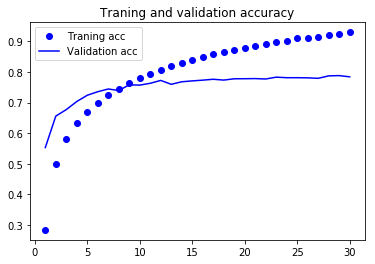

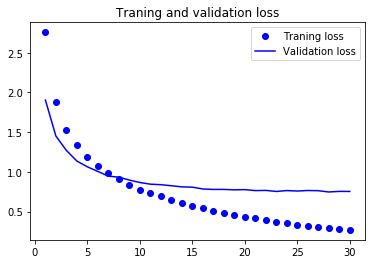

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Traning acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Traning and validation accuracy')
plt.legend()
plt.show()
plt.figure

plt.plot(epochs,loss,'bo',label='Traning loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

In [36]:
model.save('vgg16_45.h5')